In [1]:
import numpy as np
import time
from bresenham import bresenham
import itertools

#Set up 
edge_size = 500
line_opacity = .03
num_points = 200
padding = 10
random_interval = None
stopping_lookback = 10
process_start_time = time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime())

# Circle Points
theta = np.linspace(0, 2*np.pi, num_points)
a, b = edge_size * (np.cos(theta)+1)/2-1, edge_size * (np.sin(theta)+1)/2-1
points = zip([int(i) for i in a],[int(i) for i in b])
ref_lines = {}
line_scores = {}

for a,b in list(itertools.combinations(xrange(num_points),2)):
    if a>b: a,b=b,a
    ref_lines[a,b] = list(bresenham(points[a][0], points[a][1], points[b][0], points[b][1]))

    

In [2]:
import matplotlib.image as mpimg
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
%matplotlib nbagg

class Plot():
    def __init__(self, img, weights):
        self.fig = plt.figure(figsize=(12, 16))
        figtext = "edge_size: {0}\nopacity: {1}\nnum_points: {2}\npadding: {3}\nrandom_interval: {4}\nstopping_interval: {5}".format(edge_size, line_opacity, num_points, padding, random_interval, stopping_lookback)
        plt.figtext(0, 0.9, figtext, color='black', weight='roman',
            size='small')

        self.ax1 = plt.subplot2grid((5, 3), (0, 0))
        self.ax1.set_title("Target Image")
        
        self.ax8 = plt.subplot2grid((5, 3), (1, 0))
        self.ax8.set_title("Weights")
        
        self.ax2 = plt.subplot2grid((5, 3), (0, 1))
        self.ax2.set_title("Non-rasterized threads")
        self.ax2.set_xlim([0, edge_size])
        self.ax2.set_ylim([edge_size, 0])
        self.ax2.set_aspect('equal')
        
        self.ax3 = plt.subplot2grid((5, 3), (1, 1))
        self.ax3.set_title("Rasterized threads")
        
        self.ax4 = plt.subplot2grid((5, 3), (0, 2))
        self.ax4.set_title("Error")
        
        self.ax9 = plt.subplot2grid((5, 3), (1, 2))
        self.ax9.set_title("Weighted Error")
        
        self.ax5 = plt.subplot2grid((5, 3), (2, 0), colspan=3)
        self.ax5.set_title("Error improvement")
        
        self.ax6 = plt.subplot2grid((5, 3), (3, 0), colspan=3)
        self.ax6.set_title("Pin number")
        
        self.ax7 = plt.subplot2grid((5, 3), (4, 0), colspan=3)
        self.ax7.set_title("Line length")
        self.last_line = 0
        self.ax1.imshow(img, cmap="gray", vmin=0, vmax=255)
        self.ax8.imshow(weights, cmap="gray", vmin=0, vmax=255)
        
        #self.fig.subplots(figsize=(20, 10))
        #plt.tight_layout()

    def show(self, weights, raster, diff, points_log,errors, pins, lengths):
        self.ax9.imshow(np.multiply(weights/128,diff), cmap="gray", vmin=0, vmax=255)
        #lc = LineCollection([points_log[-1]], linewidths=2, alpha=0.01)
        #self.ax2.add_collection(lc)
        for i in xrange(self.last_line, len(points_log)-1):
            line_x = [points[points_log[i]][0], points[points_log[i+1]][0]]
            line_y = [points[points_log[i]][1], points[points_log[i+1]][1]]
            self.ax2.plot(line_y, line_x, alpha=line_opacity, color="k")
        #self.ax2.plot(*zip(*points), 'b.')
        self.ax3.imshow(raster, cmap="gray", vmin=0, vmax=255)
        self.ax4.imshow(diff, cmap="gray", vmin=0, vmax=255)
        self.fig.canvas.draw()
        self.ax5.plot(range(self.last_line,len(points_log)-1),errors[self.last_line:])
        self.ax6.plot(range(self.last_line,len(points_log)-1),pins[self.last_line:-1])
        self.ax7.plot(range(self.last_line,len(points_log)-1),lengths[self.last_line:])        
        self.last_line = len(points_log)


<IPython.core.display.Javascript object>


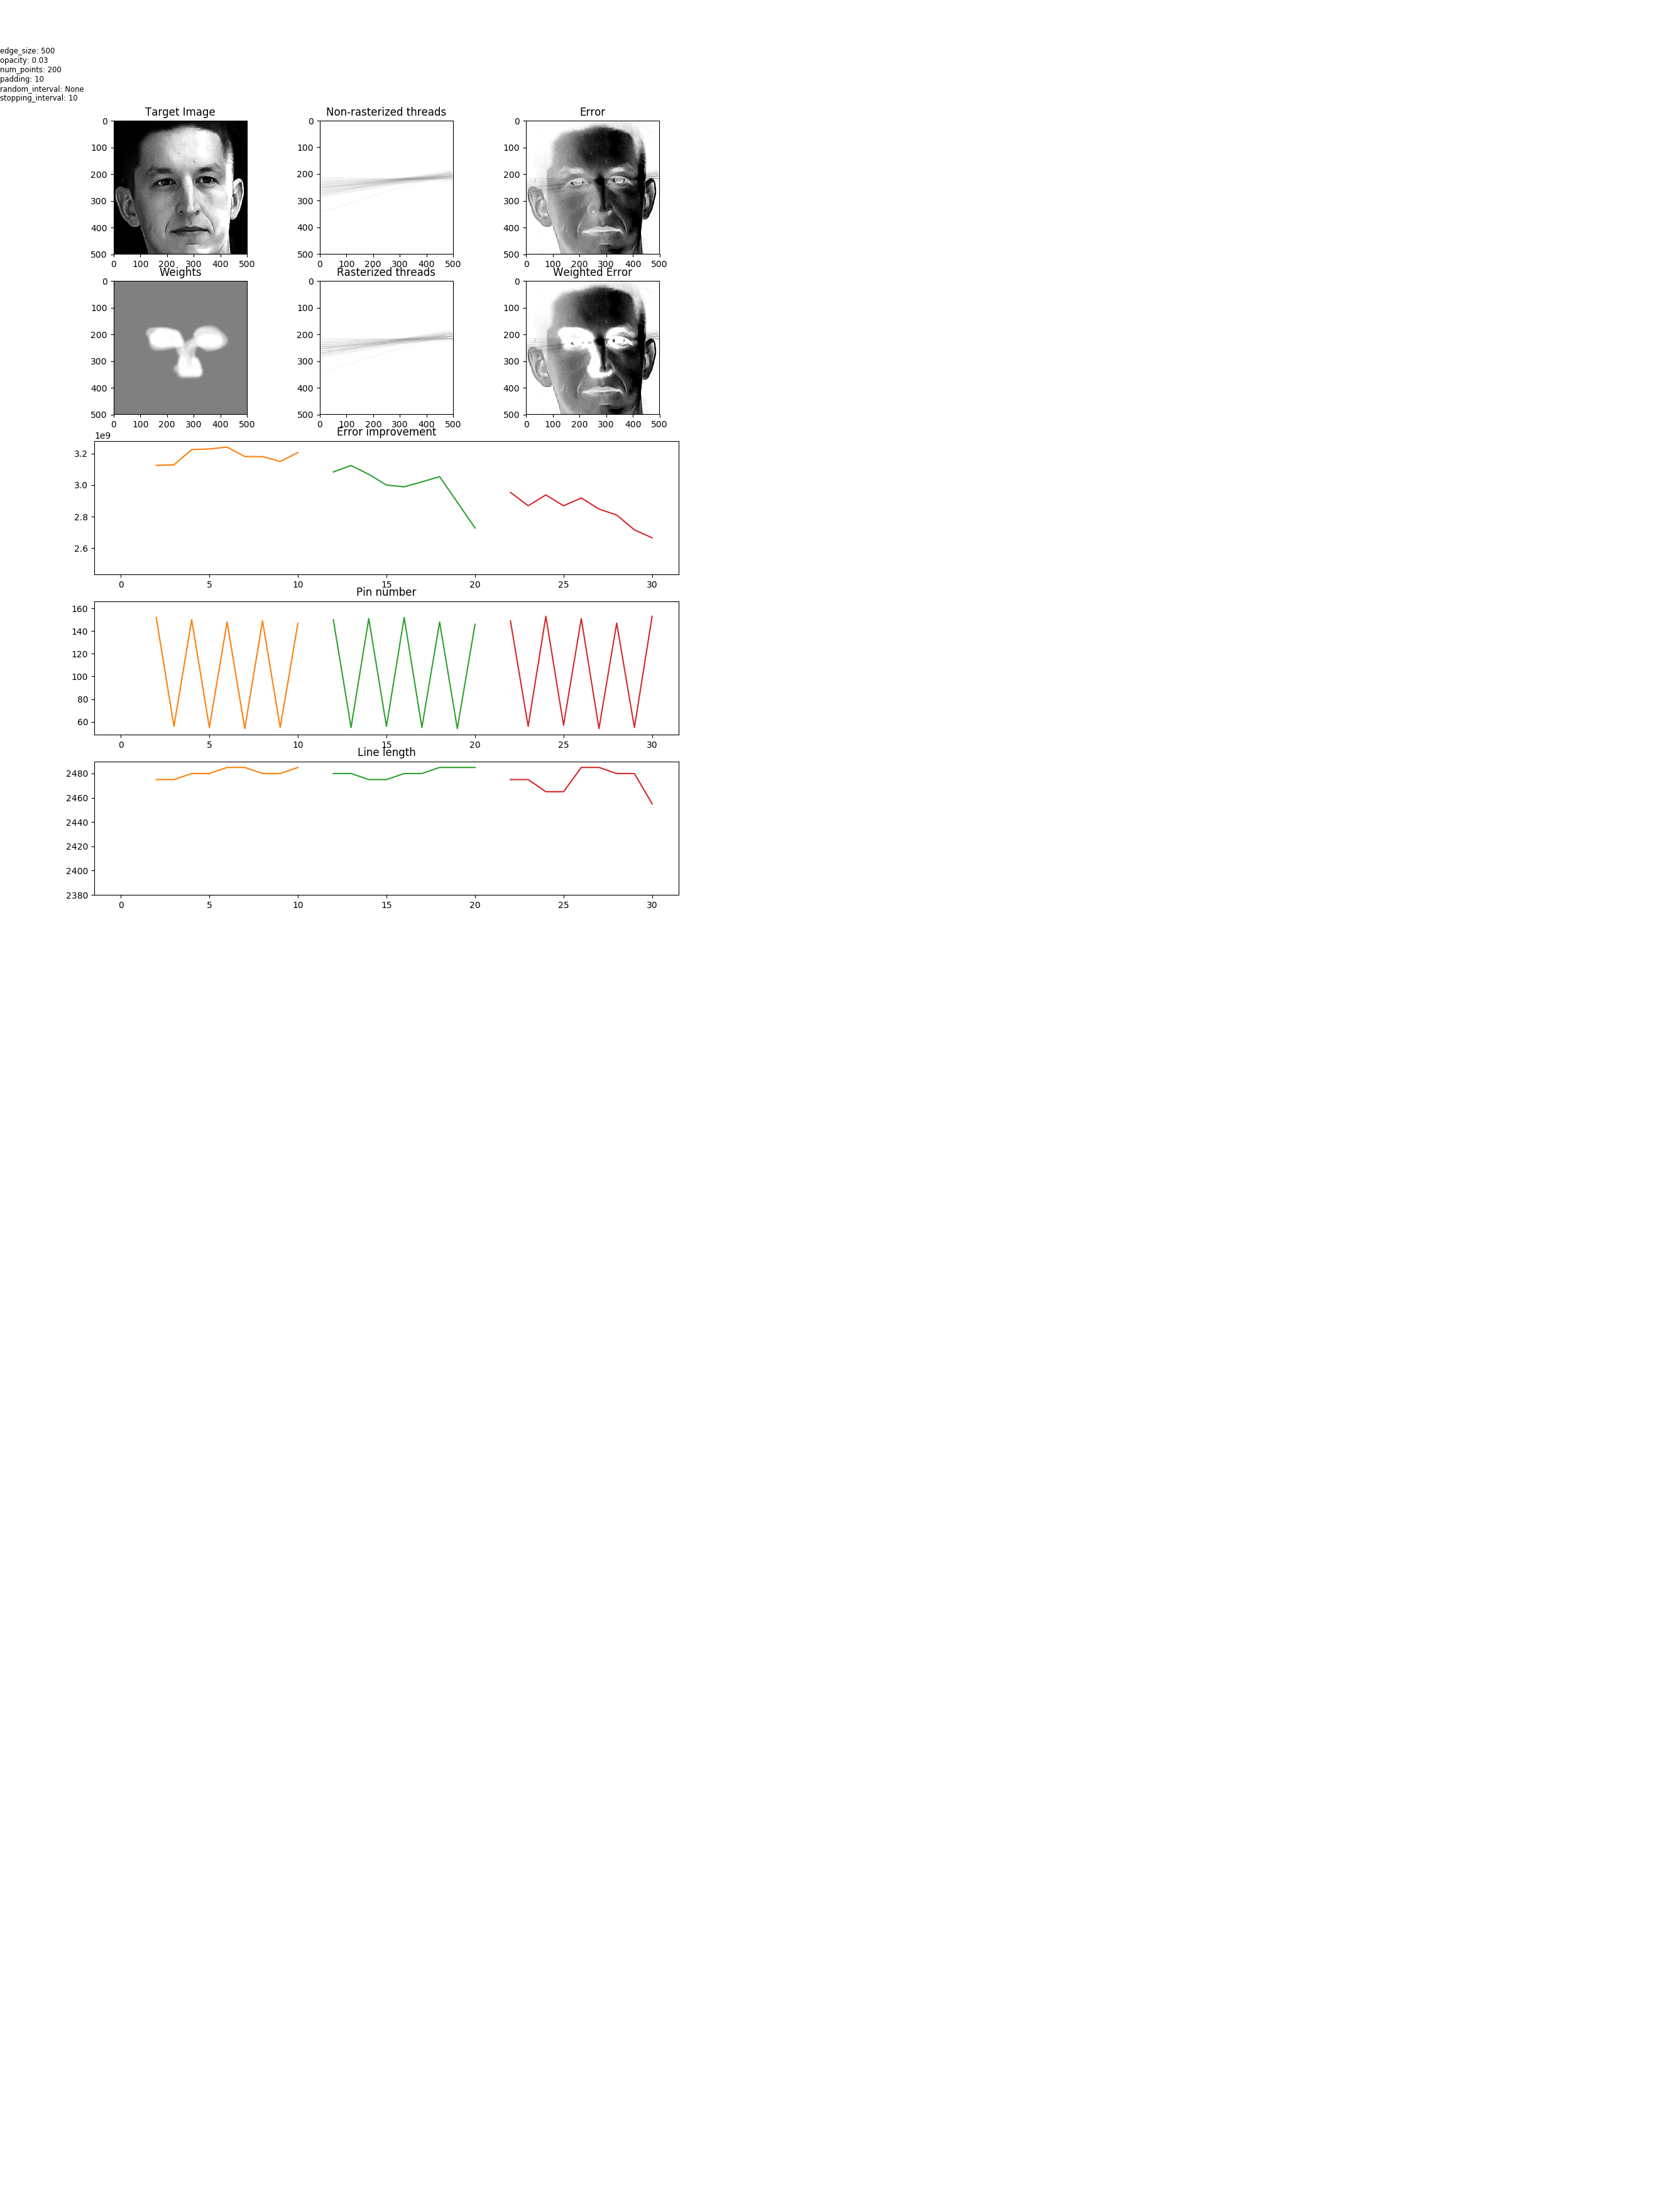

Refreshing cache took 27.8805780411 seconds
DescribeResult(nobs=1, minmax=(0.031035900115966797, 0.031035900115966797), mean=0.031035900115966797, variance=nan, skewness=0.0, kurtosis=-3.0)
DescribeResult(nobs=11, minmax=(0.028184175491333008, 0.039549112319946289), mean=0.031956477598710495, variance=1.1245664107015977e-05, skewness=1.0064573104868368, kurtosis=0.30502733432299234)
DescribeResult(nobs=21, minmax=(0.027343034744262695, 0.040630102157592773), mean=0.031343153544834683, variance=1.237780990176621e-05, skewness=1.463199676756735, kurtosis=1.3839606004668674)
DescribeResult(nobs=31, minmax=(0.027343034744262695, 0.050130128860473633), mean=0.031974131061184789, variance=2.0356133839374695e-05, skewness=2.483489468974244, kurtosis=6.901563765004354)
DescribeResult(nobs=41, minmax=(0.027343034744262695, 0.050130128860473633), mean=0.034192922638683787, variance=3.9387878388543963e-05, skewness=1.3455684779153352, kurtosis=0.7645583982859243)


KeyboardInterrupt: 

In [10]:
from scipy import ndimage
from scipy.misc import imresize
from random import randint
from scipy import stats
import pickle
import os

def get_image(f='./nerea1.jpg'):
    img = ndimage.imread(f, flatten=True)
    return img

class WheelOptimizer:
    def __init__(self, wheel):
        self.wheel = wheel
    
    # update_line_scores updates line_scores for a given line index=(p1,p2)
    def update_line_scores(self,index):
        a,b = index
        if a>b: a,b=b,a
        index = a,b
        pixels = ref_lines[index]
        score = 0 
        l1=0
        l2=0
        
        #line_scores[index] = 0.5
        #return
        # calculate score
        for pixel in pixels:
            l1+=0 # diff[pixel] * 10
            l2+=self.wheel.diff[pixel]**2 * np.sign(self.wheel.diff[pixel])
            score += self.wheel.weights[pixel] * (l1 + l2)
        line_scores[index] = float(score)/len(pixels)
        
    #refresh_line_score runs update_line_scores on all lines effectively wiping the cache
    def refresh_line_scores(self):
        cache_start_time = time.time()
        for index in ref_lines.keys():
            self.update_line_scores(index)
        print "Refreshing cache took {0} seconds".format(time.time() - cache_start_time)
        
    # get_next_point figures out what the best point is to use next given a certain state 
    # state of the wheel/optimizer
    def get_next_point(self, prev, lookahead=0):
        best_score = None
        starting_point =  prev[-1]
        
        # Determine if we're going to use a random point or not
        if random_interval!=None and randint(1, random_interval)==1:
            using_random_point = True
            random_choice = randint(0, len(points)-1)
        else:
            using_random_point = False

        keys = []
        for i in xrange(len(points)):
            # Reject lines that are too short
            if (prev[-1]-i)%num_points < padding or (prev[-1]-i)%num_points > num_points - padding: continue        
            # Reject lines going directly back to where they came from
            if (len(prev)>1 and prev[-2]==i): continue

            # Get the score of the proposed_line
            a,b = prev[-1],i
            if a>b: a,b=b,a
            score = line_scores[a,b]

            if lookahead>0: #TODO fix how this is done to normalize by length after adding together
                score += self.get_next_point([prev[-1],i], lookahead=lookahead-1)[1]

            if ((using_random_point and i==random_choice) or 
                best_score is None or 
                score>best_score):
                best_i=i
                best_score = score

            if using_random_point and i==random_choice:
                break
        return best_i, best_score, using_random_point
    
class Wheel:
    def __init__(self):
        # Config parameters
        self.LOOKAHEAD = 1
        
        self.original_img = get_image('/Users/delbalso/Downloads/dave.jpg')
        self.img = self.original_img
        self.img = imresize(((self.img - self.img.min())/self.img.max()*255).astype('uint8'),(edge_size, edge_size)).astype('float32')
        self.original_weights = get_image('/Users/delbalso/Downloads/dave-mask.jpg')
        self.weights = imresize(self.original_weights.astype('uint8'),(edge_size, edge_size)).astype('float32')
        self.p = Plot(self.img, self.weights)

        # Raster is the image we're drawing to simulate thread
        self.raster = np.zeros((edge_size, edge_size))+255
        assert self.raster.shape == self.img.shape

        self.diff = np.subtract(self.raster, self.img)
        
        # start with a random point
        self.points_log = [randint(0, len(points)-1)]
        
        self.cache_refresh_interval = 100
        self.plot_interval = 10
        
        self.wheelOptimizer = WheelOptimizer(self)
        
    # calculate runs the logic to figure out the right weaving
    def calculate(self):
        errors = []
        times = []
        lengths = []
        i = 0
        while (len(errors)<stopping_lookback or 
               sum(errors[-stopping_lookback:]) > stopping_lookback*0.125):
            if i%self.cache_refresh_interval == 0:
                self.wheelOptimizer.refresh_line_scores()

            start_time = time.time()
            next_point, err, random_point = self.wheelOptimizer.get_next_point(self.points_log[-1:],lookahead=self.LOOKAHEAD)
            #if random_point: print "random point chosen on {}".format(i)
            self.points_log.append(next_point)
            errors.append(err)

            line_pixels = get_line_pixels(self.points_log[-2],self.points_log[-1])
            lengths.append(len(line_pixels))
            draw_line(self.raster,line_pixels)
            self.wheelOptimizer.update_line_scores((self.points_log[-2],self.points_log[-1]))
            update_diff(self.diff, self.raster, self.img, line_pixels)
            times.append(time.time() - start_time)
            if i%self.plot_interval==0:
                self.p.show(self.weights,self.raster,self.diff,self.points_log, errors, self.points_log, lengths) 
                print(stats.describe (np.array(times)))
                self.save_snapshot(i)

            i = i+1
            
    def save_snapshot(self, steps):
        save_dir = os.path.join("results",process_start_time, str(steps))
        try:
            os.makedirs(save_dir)
        except:
            pass

        pickle.dump({"point_log": self.points_log,
                     "image": self.original_img,
                     "weights": self.original_weights,
                     "figure": self.p},
                    open(os.path.join(save_dir,"{0}.p".format(steps)), "wb" ))
        self.p.fig.savefig(os.path.join(save_dir,"{0}.png".format(steps)))      

# For a given line between p1 and p2, what pixels should be drawn on
def get_line_pixels(p1,p2,thickness = 5):
    line_points = []
    if p1>p2: p1,p2=p2,p1
    line_px = ref_lines[p1,p2]
    p1 = points[p1]
    p2 = points[p2]
    for px in line_px:
        if abs(p1[0]-p2[0])>abs(p1[1]-p2[1]):
            for j in xrange(thickness):
                if px[1]+j>=edge_size:
                    break
                line_points.append((px[0],px[1]+j))
        else:
            for j in xrange(thickness):
                if px[0]+j>=edge_size:
                    break
                line_points.append((px[0]+j,px[1]))
    return line_points

def draw_line(img,pixels):
    for pixel in pixels:
        img[pixel[0],pixel[1]] = max(img[pixel[0],pixel[1]] * (float(1)-line_opacity),0)

def update_diff(diff, raster, img, pixels): # optimization?
    for pixel in pixels:
        diff[pixel] = raster[pixel] - img[pixel]


    
                            

        

    
    
def main():
    w = Wheel()
    w.calculate()
    print "Finished! We drew {0} lines".format(i)

if __name__ == "__main__":
    main()